<a href="https://colab.research.google.com/github/CamiloRojasC/Chatbots-Brands/blob/main/Script_Conversational_Agents'_Impact_on_Brands.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**<h1 style="text-align:center">Scripts Paper Conversational Agents' Impact on Brands</h1>**

The following describes the code used for the different phases of analysis using machine learning throughout this article.
The document is divided into four main sections. First, module loading and processing of the documents required for analysis. Secondly, the LDA analysis process. Third, the DTM analysis. Finally, the comparative analysis code between experts and LLM for thematic modeling labeling.

<h2>Module import and document preparation</h2>

In [ ]:
%%capture
packages = ['openai', 'bertopic', 'cohere', 'gensim']
for package in packages:
    try:
        version(package)
    except:
        !pip install {package}

!pip install pyyaml==5.4.1

In [ ]:
# Bertopic
from bertopic import BERTopic
from bertopic.representation import Cohere
from umap import UMAP

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import LdaMulticore , TfidfModel
from gensim.models import ldaseqmodel
import multiprocessing

#Spacy
import spacy
sp = spacy.load('en_core_web_sm')
all_stopwords = sp.Defaults.stop_words

# OpenAI
import openai

# Additional Libraries
import cohere
import json
import os
from sklearn.decomposition import PCA
import locale
import pandas as pd
from sentence_transformers import SentenceTransformer


In [ ]:
# Loading a dataset in JSON format. As said, documents must be composed by string sentences
corpus_file = '"PLACE DOCUMENT PATH HERE'
documents_raw = json.load(open(corpus_file, 'r'))
data = [document['text'] for document in documents_raw]


def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

<h3>Functions for documents cleaning and LDA analysis</h3>

In [ ]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in all_stopwords] for doc in texts]
def remove_stopwords2(texts):
  return [[word for word in doc if word not in all_stopwords] for doc in texts]

  #return [word for doc in texts if doc not in all_stopwords]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV', 'PROPN', 'PRON', 'DET']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

In [ ]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
nlp.max_length = 2000000 # or even higher

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=15) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=5)

In [ ]:
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [ ]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [ ]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

In [ ]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [ ]:
def join_clean(data):
  new_d = []
  for i in data:
    new_d.append(" ".join(i))
  return new_d
test_clean = join_clean(data_lemmatized)

**<h2>LDA Analysis</h2>**

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
lemmatized_stoped= remove_stopwords2(data_lemmatized)
texts = data_words_nostops

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [ ]:
#### Choosing topic number via coherence scores ####

from gensim.models import CoherenceModel
coherence_values = []
model_list = []
num_passes = 20
# find chunksize to make about 200 updates
chunk_size = len(corpus) * num_passes /200

for num_topics in range(2, 21):
  model = LdaMulticore(corpus=corpus , id2word=id2word ,
                       num_topics=num_topics)
  model_list.append(model)
  coherencemodel_umass = CoherenceModel(model=model , corpus=corpus , dictionary=id2word , coherence='u_mass')

  coherencemodel_cv = CoherenceModel(model=model , corpus=corpus , dictionary=id2word , texts= texts, coherence='c_v')
  coherence_values.append((num_topics , coherencemodel_umass.
                           get_coherence(), coherencemodel_cv.get_coherence()))

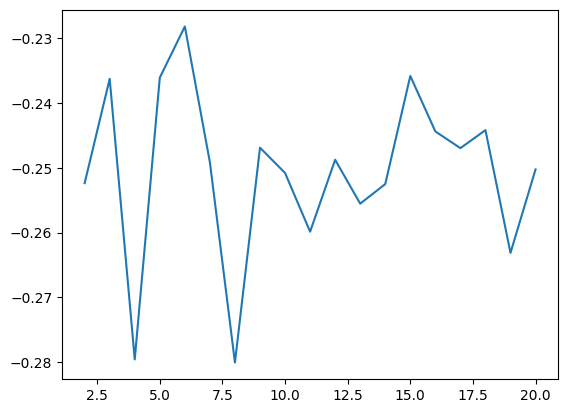

In [ ]:
results = pd.DataFrame(coherence_values)
results = results.set_axis(['topic', 'umass', 'c_v'], axis=1, inplace=False)
s = pd.Series(results.umass.values, index=results.topic.values)
_ = s.plot()

In [ ]:
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
# BEST PERFORMANCE all-mpnet-base-v2
embeddings = sentence_model.encode(test_clean, show_progress_bar=True)

Batches:   0%|          | 0/43 [00:00<?, ?it/s]

In [ ]:
# Train BERTopic
topic_model = BERTopic(nr_topics=10).fit(test_clean, embeddings)

In [ ]:
# Run the visualization with the original embeddings
topic_model.visualize_documents(test_clean, embeddings=embeddings)

In [ ]:
# Reduce dimensionality of embeddings, this step is optional but much faster to perform iteratively:
reduced_embeddings = UMAP(n_neighbors=10, n_components=8, min_dist=0.0, metric='cosine').fit_transform(embeddings)
#topic_model.visualize_documents(test_clean, reduced_embeddings=reduced_embeddings)
topic_model.visualize_documents(test_clean, reduced_embeddings=reduced_embeddings)

In [ ]:
topic_model.visualize_hierarchy(top_n_topics=10)

In [ ]:
dim_model = PCA(n_components=10)
topic_model = BERTopic(top_n_words=30, language="english", calculate_probabilities=True, verbose=True)
topic_model = BERTopic(nr_topics=10, calculate_probabilities=True).fit(test_clean)
#nr_topics=6
topics, probs = topic_model.fit_transform(test_clean, embeddings)
#topics, probs = topic_model.fit_transform(test_clean)

In [ ]:
def docs_function(list_a, list_b, topic):
  docs_list =[]
  for ind, val in enumerate(list_a):
    if list_b[ind] == topic:
      docs_list.append(val)
  return docs_list

In [ ]:
docs_topic1 = docs_function(test_clean, topics, 0)
docs_topic2 = docs_function(test_clean, topics, 1)
docs_topic3 = docs_function(test_clean, topics, 2)
docs_topic4 = docs_function(test_clean, topics, 3)
docs_topic5 = docs_function(test_clean, topics, 4)
docs_topic6 = docs_function(test_clean, topics, 5)
docs_topic7 = docs_function(test_clean, topics, 6)
docs_topic8 = docs_function(test_clean, topics, 7)
docs_topic8 = docs_function(test_clean, topics, 8)
docs_topic8 = docs_function(test_clean, topics, 9)

In [ ]:
freq = topic_model.get_topic_info(); freq.head(9)

In [ ]:
topics_list = []
for i in range (8):
  info = topic_model.get_topic(i)  # Select the most frequent topic
  my_dict = dict(info)
  topics_list.append(my_dict)

import pandas as pd
df = pd.DataFrame(topics_list)
topics_list

In [ ]:
topic_model.visualize_barchart(top_n_topics=10, n_words=20, height=300)

In [ ]:
fig = topic_model.visualize_topics()
fig

In [ ]:
###############################
#### DYNAMIC TOPIC MODELING ###
###############################
### based on thematic map ###
### 1985-2006 (326 papers), 2007-2010 (150 papers), 2011-2016 (392 papers), and 2017- early 2021 (497 papers).

In [ ]:
### 1985-2006 (326 papers), 2007-2010 (150 papers), 2011-2016 (392 papers), and 2017- early 2021 (497 papers).
time_seq = [327, 150, 397, 501]

In [ ]:
years = [document['year'] for document in documents_raw]

In [ ]:
topics_over_time = topic_model.topics_over_time(docs=test_clean,
                                                timestamps=years,
                                                global_tuning=True,
                                                evolution_tuning=True,
                                                nr_bins=10)

In [ ]:
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=10)

In [ ]:
filtered_df = topics_over_time.query('Timestamp > 1990 and Timestamp < 2000')
filtered_df

,Topic,Words,Frequency,Timestamp,Name
1,0,"design, visual, color, information, graphic",1,1991.3,0_user_use_design_robot
2,2,"repair, request, trouble, user, grant",1,1991.3,2_information_system_base_design
3,-1,"hci, display, user, screen, design",1,1994.6,-1_user_information_system_base
4,0,"requirement, course, visitor, advertiser, adve...",4,1994.6,0_user_use_design_robot
5,1,"agent, system, market, technology, decision",8,1994.6,1_agent_market_system_price
6,2,"selle, mone, buy, rule, whe",1,1994.6,2_information_system_base_design
7,-1,"user, information, system, web, datum",14,1997.9,-1_user_information_system_base
8,0,"user, design, use, call, pc",14,1997.9,0_user_use_design_robot
9,1,"agent, price, system, market, information",34,1997.9,1_agent_market_system_price
10,2,"internet, firm, electroniccommerce, market, in...",4,1997.9,2_information_system_base_design


**<h2>LARGE LANGUAGE MODEL AND EXPERTS</h2>**

In [ ]:
### based on thematic map ###
# set up OpenAI API key
openai.api_key = "PLACE YOUR openAI API KEY HERE"


# define the expert labels and GPT labels
experts_labels = [
    ['Expert 1 Topic label 1', 'Expert 1 Topic label 2', 'Expert 1 Topic label 3', 'Expert 1 Topic label 4'],
    ['Expert 2 Topic label 1', 'Expert 2 Topic label 2', 'Expert 2 Topic label 3', 'Expert 2 Topic label 4'],
    ['Expert 3 Topic label 1', 'Expert 3 Topic label 2', 'Expert 3 Topic label 3', 'Expert 3 Topic label 4'],
    ['Expert 4 Topic label 1', 'Expert 4 Topic label 2', 'Expert 4 Topic label 3', 'Expert 4 Topic label 4']
]

gpt_labels = ['GPT Topic label 1', 'GPT Topic label 2', 'GPT Topic label 3', 'GPT Topic label 4']

# initialize GPT-3 model
model_engine = "text-embedding-ada-002"


# create a function to get the GPT embeddings
def get_gpt_embeddings(text):
    response = openai.Embedding.create(
        model=model_engine,
        input=[text]
    )
    embedding = np.array(response.data[0].embedding)
    return embedding


experts_embeddings = []
for expert_labels in experts_labels:
    expert_embeddings = []
    for label in expert_labels:
        embedding = get_gpt_embeddings(label)
        expert_embeddings.append(embedding)
    experts_embeddings.append(expert_embeddings)

gpt_embeddings = []
for label in gpt_labels:
    embedding = get_gpt_embeddings(label)
    gpt_embeddings.append(embedding)


# create a function to get the label with the most similarity

def get_most_similar_label(label_embeddings, expert_embeddings, gptLabel):
    global_similarity=[]
    for indx, expert_embedding in enumerate(expert_embeddings):
        similarities = []
        for ind, label_expert in enumerate(expert_embedding):
          expert_similarity = cosine_similarity([label_embeddings], [label_expert])
          similarities.append({'score':expert_similarity[0][0], 'expert_label':experts_labels[indx][ind], 'gpt_label': gptLabel,})
        most_similar_label = np.argmax([d['score'] for d in similarities])
        # most_similar_label=0
        # print(experts_labels[indx][most_similar_label], most_similar_label, gptLabel)
        global_similarity.append({'expert': indx+1, 'similarities':similarities})
        #print(global_similarity)
    return (most_similar_label, global_similarity)

# get the most similar expert label for each GPT label
most_similar_expert_labels = []
similarity_labels = []
for indx, gpt_embedding in enumerate(gpt_embeddings):
    most_similar_label = get_most_similar_label(gpt_embedding, experts_embeddings, gpt_labels[indx])
    most_similar_expert_labels.append(most_similar_label[0])
    list_of_similarities = similarity_labels.append(most_similar_label[1])

# Concatenate all labels
all_labels = []
for label in experts_labels:
    all_labels += label
all_labels += gpt_labels

# Get embeddings for all labels
embeddings = []
for label in all_labels:
    result = openai.Embedding.create(
        engine=model_engine,
        input=[label]
    )
    embeddings.append(result.data[0].embedding)


from scipy import interpolate
from scipy.spatial import ConvexHull
# Use PCA and TSNE for dimensionality reduction
pca = PCA(n_components=48)
pca_result = pca.fit_transform(embeddings)
tsne = TSNE(n_components=2, perplexity=6)
tsne_result = tsne.fit_transform(pca_result)


"DEFINE CLUSTERS AND EXPERT COLORS"
colors = ['#ED4C67', '#F79F1F', '#F7DC6F', '#4B4E6D', '#3B3B98', '#00A8CC', '#06D6A0', '#118AB2']

# Cluster the data
kmeans = KMeans(n_clusters=8, random_state=42).fit(tsne_result)
# Get the centroids of the clusters
centroids = kmeans.cluster_centers_

# Getting points clusters
groups_kmeans = kmeans.predict(tsne_result)

#PALETTE AND MARKERS FOR CLUSTERING
col = ["#F94144", "#F3722C", "#ED4C67", "#F9C74F", "#90BE6D", "#43AA8B", "#577590", "#3B3B98"]
markers = ["D", "v", "^", "s", "p", "*"]


step = 8
predicts = []
for i in range(0, 48, step):
  x=i
  predicts.append(groups_kmeans[x:x+step])



# Plot the clusters
fig, ax = plt.subplots(figsize=(10, 10))
for i, label in enumerate(experts_labels + [gpt_labels]):
    x = tsne_result[i*8:(i+1)*8, 0]
    y = tsne_result[i*8:(i+1)*8, 1]
    info=""
    if(i<5):
      info="Expert " + str(i+1)
    else:
      info="GPT"
    ax.scatter(x, y, label=f"{info}", marker=markers[i])
    # print(np.array(predicts[i]))
    print(i, label,x, y)
    for j, txt in enumerate(label):
        info = txt
        ax.annotate(info, (x[j], y[j]), fontsize=8, c=col[groups_kmeans[j]])

for i, label in enumerate(centroids):
  ax.scatter(label[0], label[1], marker='^', s=200, c=col[i])

  new_center= centroids.astype(int)


ax.legend()
plt.show()